In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#### loading data

In [27]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

#### getting dummies on *Churn*

In [28]:
data = pd.get_dummies(data, columns=["Churn"], drop_first=True)

#### manually cleaning *TotalCharges*

In [29]:
data = data[data["TotalCharges"] != " "]
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="ignore")

#### splitting dataset into train and test sets

In [30]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=44)

data = train_set.drop(["customerID", "Churn_Yes"], axis=1)
data_labels = train_set["Churn_Yes"].copy()

#### preparing data to pipeline

In [31]:
data_num = data[["tenure", "MonthlyCharges", "TotalCharges"]]
data_cat = data.drop(columns=["tenure", "MonthlyCharges", "TotalCharges"])

#### pipeline

In [32]:
num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("poly", PolynomialFeatures(degree=3,
                                    include_bias=False,
                                    interaction_only=False)),
        ("scaler", StandardScaler()),
    ]), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

new_data = full_pipeline.fit_transform(data)

#### preparing own transformation class

In [33]:
class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold = 0.8):
        self.threshold = threshold
        print("It works!")
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):

        data = pd.DataFrame(X)
        corr_matrix = data.corr(method="spearman")
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        transformed_data = np.array(data.drop(data.columns[to_drop], axis=1))
        
        return transformed_data

In [42]:
pipeline = Pipeline([("droper", DropTransformer(threshold = 0.95))])

data_prepared = pipeline.fit_transform(new_data)

It works!


#### splitting prepared data into train and val sets

In [43]:
X_train, X_val, y_train, y_val = train_test_split(data_prepared, data_labels, test_size = 0.25,
                                                  random_state=44, stratify=data_labels)

#### learning KNN base model

In [44]:
knn_classifier = KNeighborsClassifier()

knn_classifier.fit(X_train, y_train);

#### checking model

In [45]:
y_pred = knn_classifier.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3102
           1       0.72      0.67      0.69      1116

    accuracy                           0.84      4218
   macro avg       0.80      0.79      0.79      4218
weighted avg       0.84      0.84      0.84      4218



In [46]:
y_val_pred = knn_classifier.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1035
           1       0.55      0.56      0.56       372

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.76      0.77      1407



In [47]:
scores = cross_val_score(knn_classifier, X_train, y_train,
                        scoring = "recall", cv=10)
scores

array([0.51351351, 0.54054054, 0.54464286, 0.52678571, 0.52678571,
       0.58928571, 0.41071429, 0.60714286, 0.51351351, 0.54954955])

In [48]:
print(scores.mean(), scores.std())

0.5322474259974259 0.04991629153840671


#### hyperparameters

n_neighbors, p

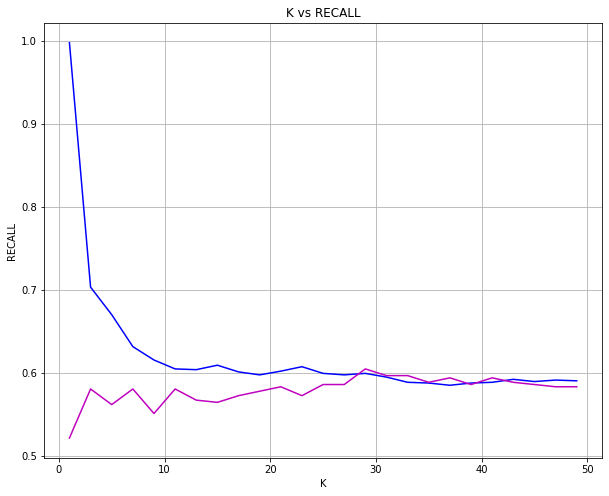

In [49]:
train_scores = []
val_scores = []

neighbors = list(range(1, 50, 2))

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_train)
    val_pred = knn.predict(X_val)
    train_scores.append(recall_score(y_train, pred))
    val_scores.append(recall_score(y_val, val_pred))              
    
plt.figure(figsize = (10, 8))
plt.xlabel('K')
plt.ylabel('RECALL')
plt.title('K vs RECALL')
plt.plot(neighbors, train_scores, 'b')
plt.plot(neighbors, val_scores, 'm')
plt.grid()

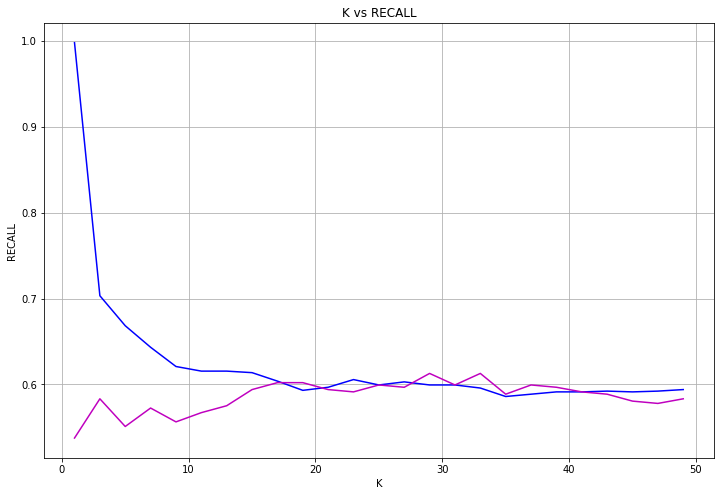

In [50]:
train_scores = []
val_scores = []

neighbors = list(range(1, 50, 2))

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, p = 1)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_train)
    val_pred = knn.predict(X_val)
    train_scores.append(recall_score(y_train, pred))
    val_scores.append(recall_score(y_val, val_pred))              
    
plt.figure(figsize = (12, 8))
plt.xlabel('K')
plt.ylabel('RECALL')
plt.title('K vs RECALL')
plt.plot(neighbors, train_scores, 'b')
plt.plot(neighbors, val_scores, 'm')
plt.grid()

#### GridSearchCV

In [51]:
%%time

grid_params = {
    "n_neighbors": [3, 5, 11, 19, 21, 23, 25, 31, 41],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
    "leaf_size": list(range(10, 100, 10)),
    "p": [1, 2, 3, 4, 5]
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    scoring = "recall",
    verbose = 1,
    cv = 10,
    n_jobs = -1
)

gs_results = gs.fit(X_train, y_train)

Fitting 10 folds for each of 1620 candidates, totalling 16200 fits
Wall time: 2min 45s


#### learning best model

In [52]:
gs_results.best_params_

{'leaf_size': 10,
 'metric': 'euclidean',
 'n_neighbors': 41,
 'p': 1,
 'weights': 'uniform'}

In [53]:
best_classifier = KNeighborsClassifier(n_neighbors = 41, leaf_size = 10, p = 1, metric = "euclidean", weights = "uniform")

best_classifier.fit(X_train, y_train);

#### checking model

In [54]:
y_pred = best_classifier.predict(X_val)

In [56]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1035
           1       0.62      0.59      0.61       372

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.73      1407
weighted avg       0.79      0.80      0.79      1407



#### threshold calibration

Best Threshold=0.341463, G-Mean=0.750


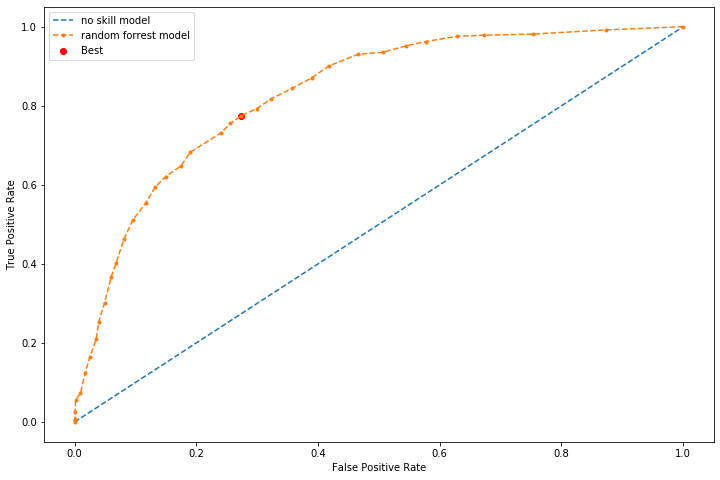

In [57]:
fpr, tpr, thresholds = roc_curve(y_val, best_classifier.predict_proba(X_val)[:,1])

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.figure(figsize = (12, 8))
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [58]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [59]:
threshold = thresholds[ix]
print(classification_report(y_val, to_labels(best_classifier.predict_proba(X_val)[:,1], threshold)))

              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.50      0.77      0.61       372

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407

